In [6]:
# 1. Environment & Imports (with path setup)
import os, time, json, sys
from pathlib import Path

# Determine project root (parent of notebooks directory)
ROOT = Path.cwd().parent  # notebooks -> upreg_classify
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))  # ensure 'src' package import works

# Diagnostic: interpreter path
print('sys.executable:', sys.executable)
# Optional: verify path injection
print('Added to sys.path:', str(ROOT) in sys.path)
print('sys.path[0]:', sys.path[0])

from autogluon.tabular import TabularPredictor
# Import project training entry
from src.train.train import train_and_evaluate

DATA_RAW = ROOT / 'data' / 'raw'
MODELS_DIR = ROOT / 'models'
print('ROOT:', ROOT)
print('Data raw exists:', DATA_RAW.exists())
print('Models dir:', MODELS_DIR)

sys.executable: c:\PythonProjects\rl_reserve_markets\.venv1\Scripts\python.exe
Added to sys.path: True
sys.path[0]: C:\Users\haako\AppData\Local\Programs\Python\Python312\python312.zip
ROOT: c:\PythonProjects\rl_reserve_markets\upreg_classify
Data raw exists: True
Models dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\models


In [7]:
# 2. Utility wrapper
import importlib
from sklearn.metrics import classification_report
from autogluon.tabular import TabularPredictor

def reload_all():
    """Reload key project modules to pick up file changes without restarting VS Code."""
    print('--- Reloading project modules ---')
    import src.data.preprocess as dp
    import src.data.features as feat
    import src.train.hyperparameters as hp
    import src.train.train as tr
    importlib.reload(dp)
    importlib.reload(feat)
    importlib.reload(hp)
    importlib.reload(tr)
    # Re-export key symbols to current namespace if needed
    from src.train.train import train_and_evaluate as _tae
    globals()['train_and_evaluate'] = _tae
    print('Reloaded: preprocess, features, hyperparameters, train')


def run_training(description: str, **kwargs):
    """Run training via train_and_evaluate and report duration + key metrics.
    Required kwargs mirror train_and_evaluate parameters.
    This cell focuses on timing + metrics JSON only.
    """
    print(f'=== Run: {description} ===')
    start = time.time()
    metrics = train_and_evaluate(**kwargs)
    dur = time.time() - start
    print(f'Completed in {dur:.1f}s')
    print(json.dumps(metrics, indent=2))
    return metrics


def show_classification_reports(metrics: dict, output_dir: str):
    """Print validation + test classification reports in a separate cell.
    Call this after run_training(...) and pass its returned metrics and output_dir.
    """
    try:
        label = None
        if isinstance(metrics, dict):
            label = metrics.get('label') or metrics.get('label_col')
        if not (output_dir and label):
            print('Missing output_dir or label in metrics; cannot build reports.')
            return
        pred = TabularPredictor.load(output_dir)
        trainer = None
        try:
            trainer = pred._learner.load_trainer()
        except Exception:
            trainer = None

        # Validation report (if val_data retained)
        if trainer is not None and getattr(trainer, 'val_data', None) is not None:
            val_data = trainer.val_data
            if label in val_data.columns:
                y_true_val = val_data[label]
                X_val = val_data.drop(columns=[label])
                y_pred_val = pred.predict(X_val)
                print('Validation classification report:')
                print(classification_report(y_true_val, y_pred_val))
        else:
            print('No validation data available on trainer; skipping val report.')

        # Test report: use stored test CSV if train_and_evaluate recorded it
        test_csv = None
        if isinstance(metrics, dict):
            test_csv = metrics.get('test_csv') or metrics.get('test_path')
        if test_csv and os.path.exists(test_csv):
            import pandas as pd
            test_df = pd.read_csv(test_csv)
            if label in test_df.columns:
                y_true_test = test_df[label]
                X_test = test_df.drop(columns=[label])
                y_pred_test = pred.predict(X_test)
                print('\nTest classification report:')
                print(classification_report(y_true_test, y_pred_test))
        else:
            if not test_csv:
                print('No test_csv/test_path in metrics; skipping test report.')
            elif not os.path.exists(test_csv):
                print(f'Test CSV path not found: {test_csv}')
    except Exception as e:
        print('Could not generate classification reports:', e)


def base_common(area='NO1'):
    return dict(
        task='multiclass',
        area=area,
        data_dir=str(DATA_RAW),
        include_2024=True,
        heavy_interactions=False,
        dropna=True,
        train_frac=0.6, val_frac=0.2, test_frac=0.2,
        activation_lag_start=4,
        single_persistence=True,
        weight_factor_up=1.0, weight_factor_down=1.0, weight_factor_none=1.0,
        tune_up_bias=True, tune_up_objective='macro',
        num_bag_folds=0, num_stack_levels=0,
        importance_time_limit=60, importance_subsample=1200, importance_top_n=100,
        use_categorical_reglag=False,
        data_start=None,
    )

In [ ]:
# 3. Quick RF/XT priority baseline (NO1)
baseline_cfg = base_common(area='NO1')
baseline_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'baseline_rf_xt_priority'),
    time_limit=500,
    presets='best_quality',
    model_preset='rf_xt_priority',
    hpo_trials=0, hpo_searcher='random', hpo_scheduler='local',
))
# Uncomment to run
# run_training('Baseline RF/XT Priority NO1', **baseline_cfg)

=== Run: CatBoost-only HPO(4) NO1 ===
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.94 GB / 13.85 GB (21.2%)
Disk Space Avail:   381.36 GB / 952.62 GB (40.0%)
Presets specified: ['best_quality']
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.94 GB / 13.85 GB (21.2%)
Disk Space Avail:   381.36 GB / 952.62 GB (40.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1


Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
flows shape: (67584, 8)
Number of NaNs before dropna: 14217
Final preprocessed DataFrame shape: (65720, 69)
Dataset splits: train=39432, val=13144, test=13144 (total=65720)


Beginning AutoGluon training ... Time limit = 500s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\cat_only_hpo4_no_bag"
Train Data Rows:    39432
Train Data Columns: 63
Tuning Data Rows:    13144
Tuning Data Columns: 63
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\cat_only_hpo4_no_bag"
Train Data Rows:    39432
Train Data Columns: 63
Tuning Data Rows:    13144
Tuning Data Columns: 63
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'Int8Dtype()' as a data type
	Available Memory:                    2971.89 MB
	Train Data (Original)  Memory Usage: 23.22 MB (0.8% of availa

  0%|          | 0/15 [00:00<?, ?it/s]

Fitted model: CatBoost\T1 ...
	0.4877	 = Validation score   (f1_macro)
	48.13s	 = Training   runtime
	0.01s	 = Validation runtime
	0.4877	 = Validation score   (f1_macro)
	48.13s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CatBoost\T2 ...
	0.4814	 = Validation score   (f1_macro)
	10.01s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CatBoost\T3 ...
Fitted model: CatBoost\T2 ...
	0.4814	 = Validation score   (f1_macro)
	10.01s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CatBoost\T3 ...
	0.5058	 = Validation score   (f1_macro)
	7.68s	 = Training   runtime
	0.01s	 = Validation runtime
	0.5058	 = Validation score   (f1_macro)
	7.68s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CatBoost\T4 ...
	0.4777	 = Validation score   (f1_macro)
	39.18s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CatBoost\T4 ...
	0.4777	 = Validation score   (f1_macro)
	39.18s	 = Training   runtime
	0.01s	 = Validation 

Tuning up-multiplier alpha=0.75: F1(up)=0.1057, F1(macro)=0.4746
Tuning up-multiplier alpha=0.90: F1(up)=0.1769, F1(macro)=0.4983
Tuning up-multiplier alpha=1.00: F1(up)=0.2288, F1(macro)=0.5156
Tuning up-multiplier alpha=1.10: F1(up)=0.2599, F1(macro)=0.5258
Tuning up-multiplier alpha=1.18: F1(up)=0.2839, F1(macro)=0.5336
Tuning up-multiplier alpha=1.25: F1(up)=0.3026, F1(macro)=0.5398
Tuning up-multiplier alpha=1.30: F1(up)=0.3099, F1(macro)=0.5421
Tuning up-multiplier alpha=1.38: F1(up)=0.3277, F1(macro)=0.5479
Tuning up-multiplier alpha=1.45: F1(up)=0.3311, F1(macro)=0.5490
Tuning up-multiplier alpha=1.50: F1(up)=0.3338, F1(macro)=0.5498
Tuning up-multiplier alpha=1.25: F1(up)=0.3026, F1(macro)=0.5398
Tuning up-multiplier alpha=1.30: F1(up)=0.3099, F1(macro)=0.5421
Tuning up-multiplier alpha=1.38: F1(up)=0.3277, F1(macro)=0.5479
Tuning up-multiplier alpha=1.45: F1(up)=0.3311, F1(macro)=0.5490
Tuning up-multiplier alpha=1.50: F1(up)=0.3338, F1(macro)=0.5498
Tuning up-multiplier alph

These features in provided data are not utilized by the predictor and will be ignored: ['NO1-NO2_ratio_dup1', 'NO1-NO3_ratio_dup1', 'NO1-NO5_ratio_dup1', 'NO1-SE3_ratio_dup1']
Computing feature importance via permutation shuffling for 59 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	14.26s	= Expected runtime (1.43s per shuffle set)
Computing feature importance via permutation shuffling for 59 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	14.26s	= Expected runtime (1.43s per shuffle set)
	2.26s	= Actual runtime (Completed 10 of 10 shuffle sets)
	2.26s	= Actual runtime (Completed 10 of 10 shuffle sets)


Top feature importances:
  RegLag-4: 0.159690
  Up-Down Price Skew: 0.059633
  PriceUp - DA: 0.052986
  PriceDown - DA: 0.050592
  RegLag-5: 0.042898
  RegLag-9: 0.022761
  PriceUp/DA Ratio: 0.022754
  PriceDown/DA Ratio: 0.022151
  RegLag-7: 0.018117
  RegLag-6: 0.011912
  RegLag-14: 0.005494
  RegLag-12: 0.005028
  RegLag-8: 0.004351
  Price Symm Rel Diff: 0.003783
  DA/ID Price Ratio: 0.002477
  Consumption / Production: 0.002265
  RegLag-10: 0.001905
  Import/Consumption: 0.001569
  NO1-SE3_ratio: 0.001537
  Residual Load: 0.001307
  RegLag-11: 0.001291
  HOD: 0.001082
  Net Import Ramp: 0.001075
  aFRR Down Quantity: 0.000928
  Accepted Up Share: 0.000860
  Consumption: 0.000833
  wind_error_t+4: 0.000774
  PriceDown_t-1: 0.000505
  Total Imports: 0.000386
  Accepted Imbalance Ratio: 0.000345
  Total Production: 0.000303
  month_sin: 0.000270
  hour_cos: 0.000160
  DA Scarcity: 0.000125
  wind_error_t+2: 0.000000
  PriceUp_t-1: 0.000000
  aFRR_ActCat-6: 0.000000
  aFRR Down Price:

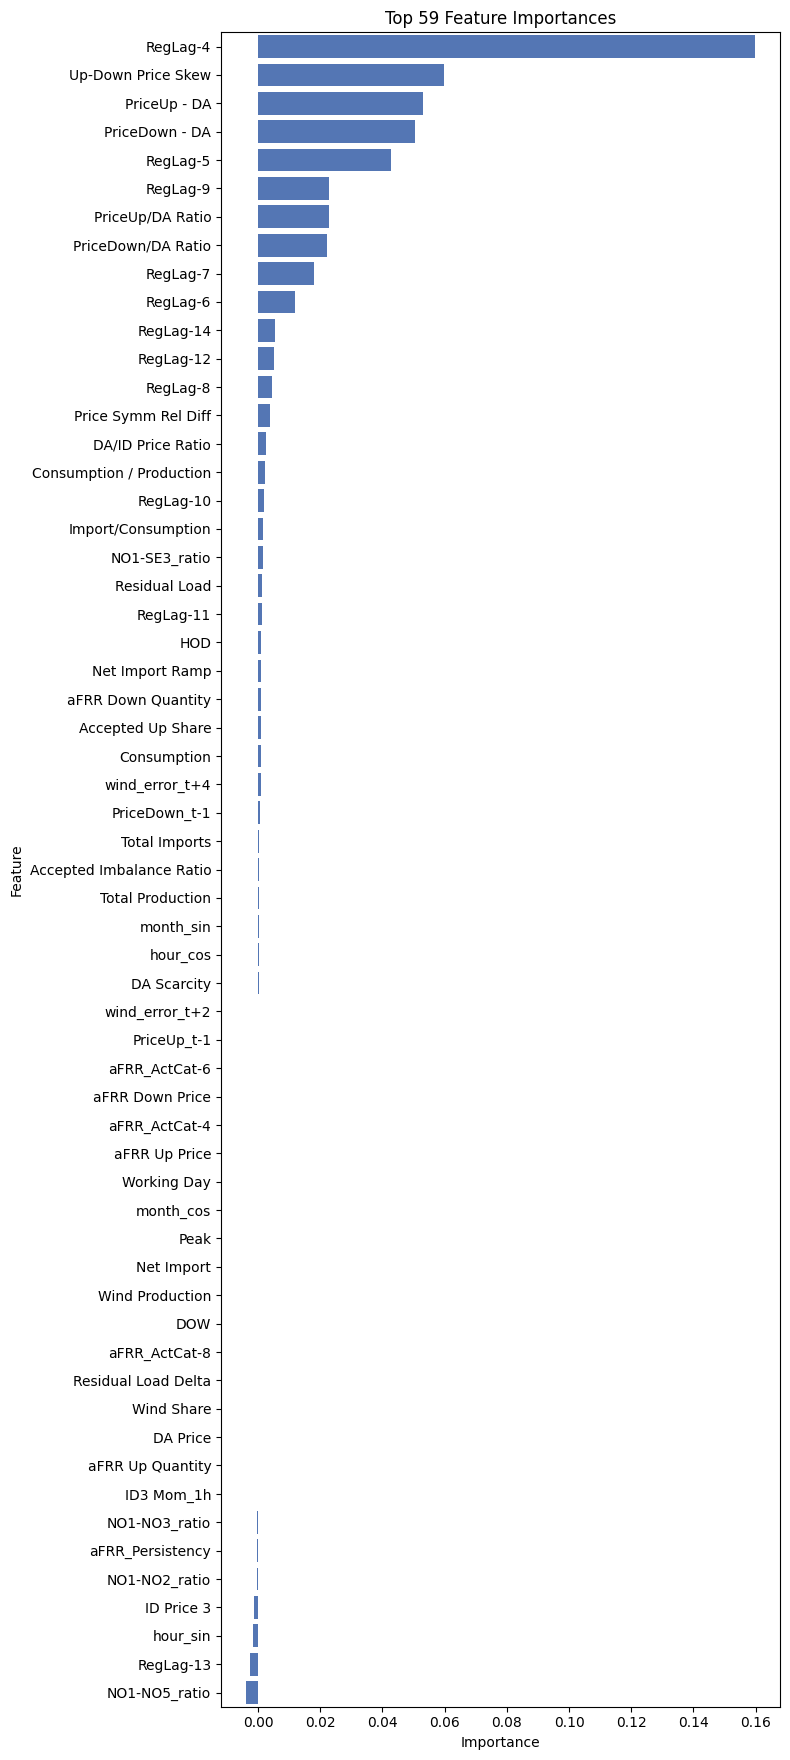

In [14]:

# 4. CatBoost-only + HPO trials (NO1)
cat_hpo_cfg = base_common(area='NO1')
cat_hpo_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'cat_only_hpo4_no_bag'),
    time_limit=500,
    presets='best_quality',
    model_preset='cat_only',
    #data_start='2025-03-04',
    
    hpo_trials=15, hpo_searcher='random', hpo_scheduler='local',
    #only_persistency_features=True
    exclude_persistency_features=True
))
# Uncomment to run
run_training('CatBoost-only HPO(4) NO1', **cat_hpo_cfg)


In [ ]:
# 5. Baseline RF/XT priority for NO2 (area switch)
no2_baseline_cfg = base_common(area='NO2')
no2_baseline_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'baseline_rf_xt_priority_NO2'),
    time_limit=120,
    presets='best_quality',
    model_preset='rf_xt_priority',
    hpo_trials=0, hpo_searcher='random', hpo_scheduler='local',
))
# Uncomment to run
# run_training('Baseline RF/XT Priority NO2', **no2_baseline_cfg)

In [ ]:
# 6. Stacking example (rf_xt_boost_stack) with modest time limit
stack_cfg = base_common(area='NO1')
stack_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'stack_rf_xt_boost'),
    time_limit=300,
    presets='best_quality',
    model_preset='rf_xt_boost_stack',
    num_bag_folds=0, num_stack_levels=0,  # keep disabled per requirement
    hpo_trials=0,
))
# Uncomment to run
# run_training('Stack Config (no actual bag/stack) NO1', **stack_cfg)

In [ ]:
# 7. Batch runner: choose which configs to execute in sequence
batch = [
    # ('Baseline NO1', baseline_cfg),
    # ('CatBoost HPO4 NO1', cat_hpo_cfg),
    # ('Baseline NO2', no2_baseline_cfg),
]
results = {}
for name, cfg in batch:
    metrics = run_training(name, **cfg)
    results[name] = metrics
if results:
    print('Summary (macro F1):', {k: v.get('val_f1_macro') for k, v in results.items()})

### Notes
- Increase `time_limit` substantially (e.g., 1800+) for higher quality models.
- Set class weighting (e.g., `weight_factor_up=1.3`) to emphasize minority classes.
- Enable categorical RegLag features via `use_categorical_reglag=True` if desired.
- For persistence across re-runs, choose distinct `output_dir` names.

In [ ]:
# XGBoost-only (no HPO) sanity run
xgb_cfg = base_common(area='NO1')
xgb_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_only_baseline_light'),
    time_limit=180,
    presets='medium_quality',
    model_preset='xgb_only',
    hpo_trials=0,               # disable HPO to isolate training
    hpo_searcher='random',
    hpo_scheduler='local',
    #data_start='2025-06-01',    # keep subset for speed
))
run_training('XGBoost-only BASELINE NO1 LIGHT', **xgb_cfg)


In [ ]:
# 8. XGBoost-only FULL run (fixed variants, full data)
xgb_full_cfg = base_common(area='NO1')
xgb_full_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_only_full_fixed_actual'),
    time_limit=1800,             # 30 minutes budget; adjust as needed
    presets='best_quality',
    model_preset='xgb_only_fixed',
    hpo_trials=0,                # no HPO; use fixed variants
    hpo_searcher='random',
    hpo_scheduler='local',
    data_start=None,             # ensure full dataset
))
run_training('XGBoost-only FULL FIXED VARIANTS NO1', **xgb_full_cfg)


In [ ]:
# 10. Inspect trained model families from saved predictors
from autogluon.tabular import TabularPredictor
paths = [
    MODELS_DIR / 'xgb_only_full_fixed',
    MODELS_DIR / 'xgb_only_full_fixed_actual',
    MODELS_DIR / 'xgb_only_full_hpo6',
    MODELS_DIR / 'xgb_only_full_hpo2_quick',
]
for p in paths:
    p = str(p)
    if Path(p).exists():
        try:
            pred = TabularPredictor.load(p)
            print(f'Path: {p}')
            print('Models:', pred.model_names())
        except Exception as e:
            print(f'Failed to load {p}:', e)


In [ ]:
# 11. Force-reload training modules to pick up latest hyperparameter presets
import importlib
import src.train.hyperparameters as hp
import src.train.train as tr
hp = importlib.reload(hp)
tr = importlib.reload(tr)
from src.train.hyperparameters import build_hyperparameters
print('xgb_only_fixed keys:', list(build_hyperparameters('xgb_only_fixed', hpo_trials=0).keys()))


In [ ]:
# 12. Sanity: XGBoost-only FIXED on subset, verify model families
xgb_subset_cfg = base_common(area='NO1')
xgb_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_only_fixed_subset_check'),
    time_limit=1000,
    presets='best_quality',
    model_preset='xgb_only_fixed',
    hpo_trials=5,
    data_start='2025-03-04',
))
metrics = run_training('XGB FIXED SUBSET CHECK', **xgb_subset_cfg)
# Show trained models
pred = TabularPredictor.load(xgb_subset_cfg['output_dir'])
print('Models:', pred.model_names())


In [ ]:
# 13. Sanity: CatBoost-only on subset, mirror cfg of #12
from src.train.train import train_and_evaluate
reload_all()
cat_subset_cfg = base_common(area='NO1')
cat_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'cat_only_subset_check'),
    time_limit=600,
    presets='best_quality',
    model_preset='cat_only',
    hpo_trials=2,
    data_start='2025-03-04',
))
metrics = run_training('CAT ONLY SUBSET CHECK', **cat_subset_cfg)
# Show trained models
pred = TabularPredictor.load(cat_subset_cfg['output_dir'])
print('Models:', pred.model_names())


In [ ]:
# 14. Sanity: LightGBM-only on subset, mirror cfg of #12
lgbm_subset_cfg = base_common(area='NO1')
lgbm_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'lgbm_only_subset_check'),
    time_limit=1000,
    presets='best_quality',
    model_preset='lgbm_only',
    hpo_trials=0,
    data_start='2025-03-04',
))
metrics = run_training('LGBM ONLY SUBSET CHECK', **lgbm_subset_cfg)
# Show trained models
pred = TabularPredictor.load(lgbm_subset_cfg['output_dir'])
print('Models:', pred.model_names())


In [ ]:
# 15. Subset run with persistency interactions disabled (XGB fixed)
xgb_no_inter_subset_cfg = base_common(area='NO1')
xgb_no_inter_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_fixed_subset_no_interactions'),
    time_limit=600,
    presets='medium_quality',
    model_preset='xgb_only_fixed',
    hpo_trials=0,
    data_start='2025-03-04',
    disable_persistency_interactions=True,
))
metrics = run_training('XGB FIXED SUBSET NO INTERACTIONS', **xgb_no_inter_subset_cfg)
# Show trained models
pred = TabularPredictor.load(xgb_no_inter_subset_cfg['output_dir'])
print('Models:', pred.model_names())


In [ ]:
# 16. LightGBM-only HPO on subset (verify only GBM models)
lgbm_hpo_subset_cfg = base_common(area='NO1')
lgbm_hpo_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'lgbm_only_subset_hpo'),
    time_limit=900,
    presets='best_quality',
    model_preset='lgbm_only',
    hpo_trials=4,
    hpo_searcher='random',
    hpo_scheduler='local',
    data_start='2025-03-04',
))
metrics = run_training('LGBM ONLY HPO(4) SUBSET CHECK', **lgbm_hpo_subset_cfg)
# Show trained models
pred = TabularPredictor.load(lgbm_hpo_subset_cfg['output_dir'])
print('Models:', pred.model_names())

In [ ]:
# 17. Inspect features after persistency-interactions disabled run
# Load predictor from cell #15 output_dir and list any Persistency interaction features
from autogluon.tabular import TabularPredictor
p = TabularPredictor.load(xgb_no_inter_subset_cfg['output_dir'])
feat_names = []
try:
    feat_names = list(p.feature_metadata.get_features())
except Exception:
    try:
        feat_names = list(p._learner.feature_metadata_in.get_features())
    except Exception:
        try:
            feat_names = list(p._learner.features)
        except Exception:
            feat_names = []
print('Total features:', len(feat_names))
bad = [f for f in feat_names if (' x Persistency' in f) or ('Persistency x ' in f) or (' x PersistencyDown' in f) or ('PersistencyDown x ' in f)]
print('Persistency-interaction features found:', bad)

In [20]:
# 18. Baseline: last-observed-class (RegClass+4 = RegClass-4) + conditional probs
import pandas as pd
from sklearn.metrics import classification_report

# Reload preprocessing to ensure we use the latest pipeline
reload_all()
import src.data.preprocess as dp
from src.data.preprocess import Config

# Build full dataset using the same config defaults as training
cfg = Config()
df_full = dp.preprocess_all(cfg=cfg)
# Optionally focus on the last 20% of rows (comment out if undesired)
df_full = df_full.iloc[int(len(df_full) * 0.8):]

label_col = 'RegClass+4'
cond_col = 'RegLag-4'   # condition on previous numeric direction {-1,0,1}
baseline_col = 'RegLag-4'  # numeric {-1,0,1} from mFRR; map to classes

for col in [label_col, cond_col, baseline_col]:
    if col not in df_full.columns:
        raise KeyError(f'Missing required column {col} in df.')

# Map numeric RegLag-4 back to class labels used by RegClass+4
dir_to_class = {1: 'up', -1: 'down', 0: 'none'}
y_true = df_full[label_col].astype(str)
lag_numeric = df_full[baseline_col]
y_pred = lag_numeric.map(dir_to_class).astype(str)

print('Last-observed-class baseline: RegClass+4 ≈ RegClass-4 (via RegLag-4)')
print(classification_report(y_true, y_pred))

# Conditional probabilities: P(RegClass+4 = y | RegLag-4 = x)
print('\nConditional probabilities P(RegClass+4 = y | RegLag-4 = x)')
prev_dir = lag_numeric
valid_dir_values = [-1, 0, 1]
mask = prev_dir.isin(valid_dir_values) & y_true.isin(['up', 'down', 'none'])

# Crosstab over numeric RegLag-4 vs class label
ct = pd.crosstab(prev_dir[mask], y_true[mask], rownames=['RegLag-4 (given)'], colnames=['RegClass+4 (target)'])
row_perc = ct.div(ct.sum(axis=1), axis=0) * 100
row_perc = row_perc.reindex(index=valid_dir_values, columns=['up', 'down', 'none'])
print(row_perc.round(2))

--- Reloading project modules ---
Reloaded: preprocess, features, hyperparameters, train
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
flows shape: (67584, 8)
Number of NaNs before dropna: 14217
Final preprocessed DataFrame shape: (65720, 69)
Last-observed-class baseline: RegClass+4 ≈ RegClass-4 (via RegLag-4)
              precision    recall  f1-score   support

  